In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

sns.set_theme("paper")
sns.set_style("whitegrid")

In [2]:
import os

DATA_DIR = "/home/ubuntu/data"

corona_ann = sc.read_h5ad(os.path.join(DATA_DIR, "COVAC_corrected_annotated.h5ad"))

In [3]:
# manually build ordinal annotation
corona_ann.obs["ordinal_label"] = corona_ann.obs.timepoint.replace({"t1": 0, "t2": 1, "t3": 2, "t4": 3,
                                                                        "d1": 0, "d28": 1, "d56": 2, "M6": 3}).astype("int8")

corona_ann.obs.ordinal_label

new_index
AAACCCACAAGCCCAC-59    2
AAACCCATCTTGTTAC-59    2
AAACGAAAGACAACTA-59    2
AAACGAACATGGGTTT-59    2
AAACGCTTCACTCGAA-59    2
                      ..
TTTGTTGTCGGCCTTT-42    1
TTTGTTGTCGGTAGAG-42    1
TTTGTTGTCGTGGACC-42    1
TTTGTTGTCTATCGGA-42    1
TTTGTTGTCTGTTGGA-42    1
Name: ordinal_label, Length: 398598, dtype: int8

## Subset by cohorts

In [4]:
corona_b = corona_ann[corona_ann.obs.cohort == "B"].copy()

In [5]:
list(corona_b.obs.cell_type.unique())

['CD4+ T',
 'CLP',
 'B',
 'naive CD4+ T',
 'T/NK',
 'MK',
 'CD8+ T',
 nan,
 'HSC',
 'NK',
 'CD4+ Treg',
 'naive CD8+ T',
 'Plasma']

In [34]:
cd4 = ["naive CD4+ T", "CD4+ Treg", "CD4+ T"]
cd8 = ["CD8+ T", "naive CD8+ T"]
t_cells = cd4 + cd8
b_cells = ["B", "Plasma"]

## Run on Cohort B

### Run on T-cells and B-cells

In [ ]:
from pypsupertime import Psupertime

# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 75, "n_iter_no_change": 20, "max_iter": 500}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

psuper_b_all_ = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_b_all = psuper_b_all.run(corona_b[corona_b.obs.cell_type.isin(t_cells + b_cells)].copy(), "ordinal_label")

In [56]:
from pypsupertime import Psupertime

# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 75, "n_iter_no_change": 20, "max_iter": 500}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

psuper_b_all = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_b_all = psuper_b_all.run(corona_b[corona_b.obs.cell_type.isin(t_cells + b_cells)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=126626
Preprocessing: done. mode='hvg', n_genes=1632, n_cells=126626
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.395874.02, n_genes=0
Total elapsed time:  6:00:25.944584


Best idx: 17 Best Score: 0.4141721184578369 Best Lambda: 0.00982315593230438 Scores std: 0.027787761158915472
1SE idx: 6 1SE Score: 0.3958744649338276 1SE Lambda: 0.07976538939166479


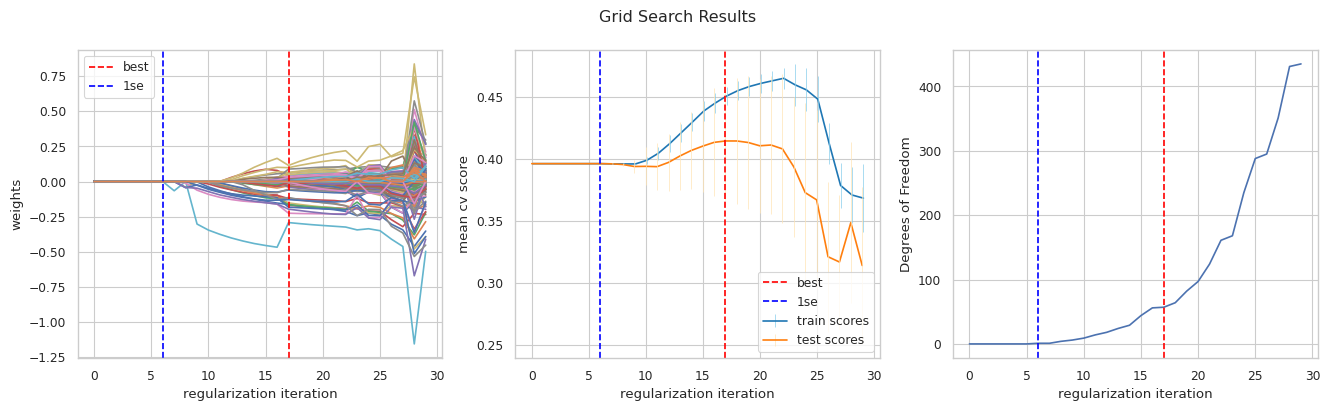

In [57]:
fig = psuper_b_all.plot_grid_search()

In [59]:
psuper_b_all.refit_and_predict(cohort_b_all, "best")

Input Data: n_genes=1632, n_cells=126626
Refit on all data: done. accuracy=0.447420.02, n_genes=56


Model Degrees of freedom 56
Accuracy: 0.4474199611454204
Balanced accuracy: 0.3414422345901843
Mean absolute delta: 1.1720541785836822


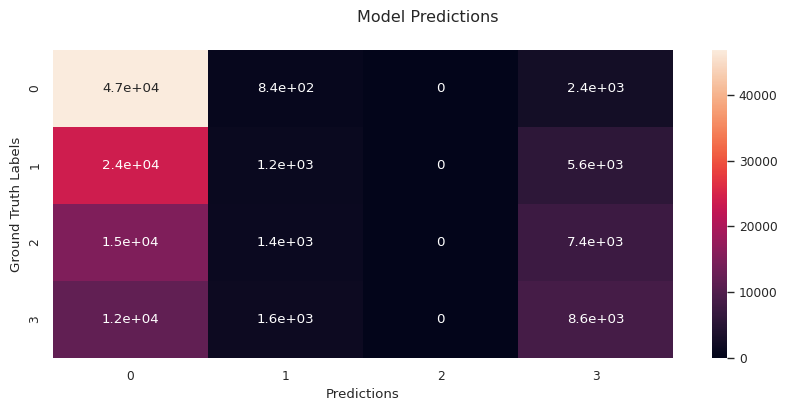

In [60]:
fig = psuper_b_all.plot_model_perf(train=(cohort_b_all.X, cohort_b_all.obs.ordinal_label))

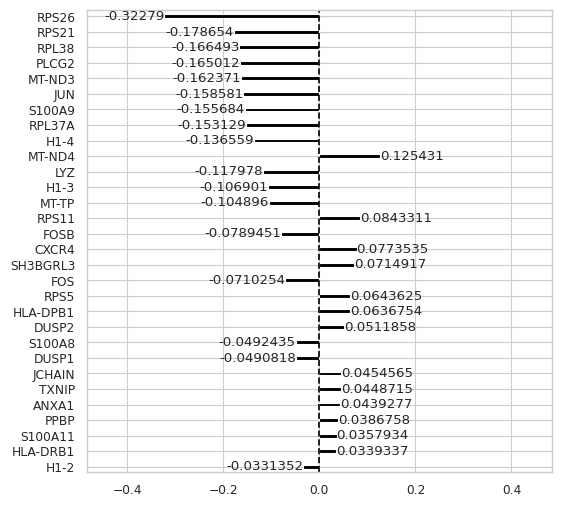

In [61]:
fig = psuper_b_all.plot_identified_gene_coefficients(cohort_b_all)

### Run on CD4+ T-cells

In [33]:
# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 50, "max_iter": 500}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

In [35]:
from pypsupertime import Psupertime
psuper_b_cd4 = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_b_cd4 = psuper_b_cd4.run(corona_b[corona_b.obs.cell_type.isin(cd4)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=75919
Preprocessing: done. mode='hvg', n_genes=2164, n_cells=75919
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.407303.02, n_genes=0
Total elapsed time:  3:05:59.867111


Best idx: 0 Best Score: 0.4073025197264951 Best Lambda: 0.25 Scores std: 0.032343387935107284
1SE idx: 0 1SE Score: 0.4073025197264951 1SE Lambda: 0.25


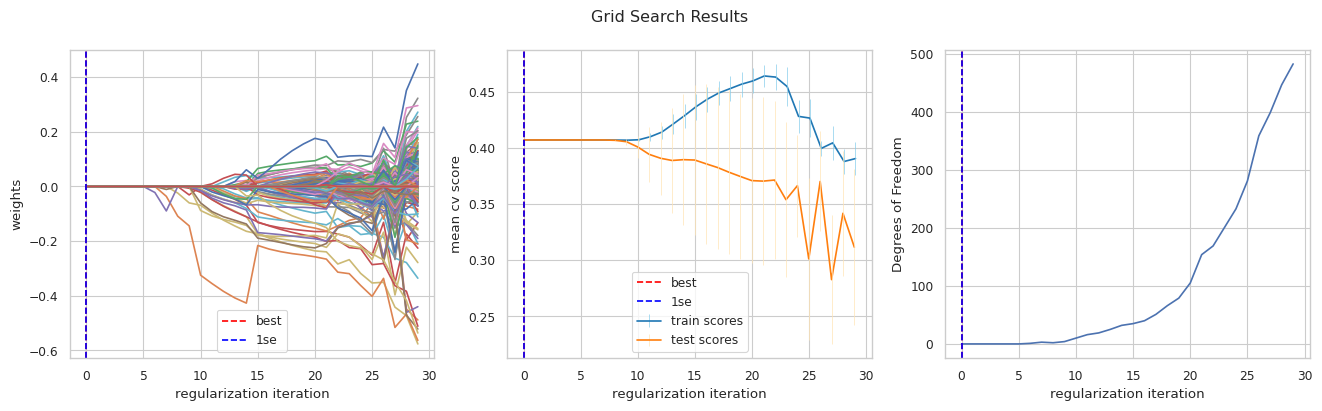

In [38]:
fig = psuper_b_cd4.plot_grid_search()

In [39]:
psuper_b_cd4.refit_and_predict(cohort_b_cd4, "index", 21)

Input Data: n_genes=2164, n_cells=75919
Refit on all data: done. accuracy=0.453958.02, n_genes=135


Model Degrees of freedom 135
Accuracy: 0.4539575073433528
Balanced accuracy: 0.3450048704379529
Mean absolute delta: 1.0929470838179756


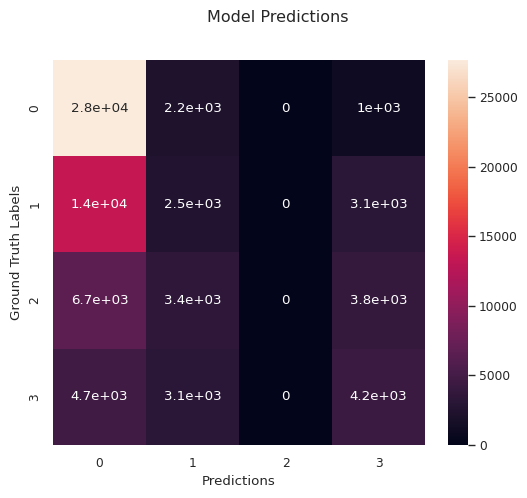

In [43]:
fig = psuper_b_cd4.plot_model_perf(train=(cohort_b_cd4.X, cohort_b_cd4.obs.ordinal_label), figsize=(6,5))

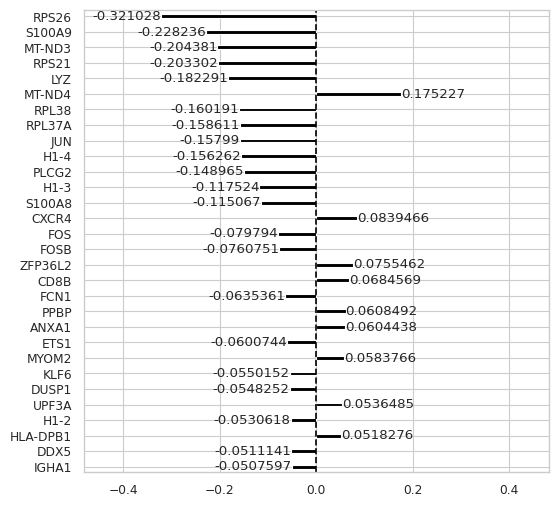

In [45]:
fig = psuper_b_cd4.plot_identified_gene_coefficients(cohort_b_cd4)

### Run on CD4+ active T-cells

In [54]:
from pypsupertime import Psupertime

regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 100, "max_iter": 500}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

cd4active = ["CD4+ Treg", "CD4+ T"]

psuper_b_cd4active = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_b_cd4active = psuper_b_cd4active.run(corona_b[corona_b.obs.cell_type.isin(cd4active)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=35425
Preprocessing: done. mode='hvg', n_genes=1908, n_cells=35425
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.389442.02, n_genes=0
Total elapsed time:  2:11:38.391723


Best idx: 0 Best Score: 0.3894424841213832 Best Lambda: 0.25 Scores std: 0.02079003428389849
1SE idx: 0 1SE Score: 0.3894424841213832 1SE Lambda: 0.25


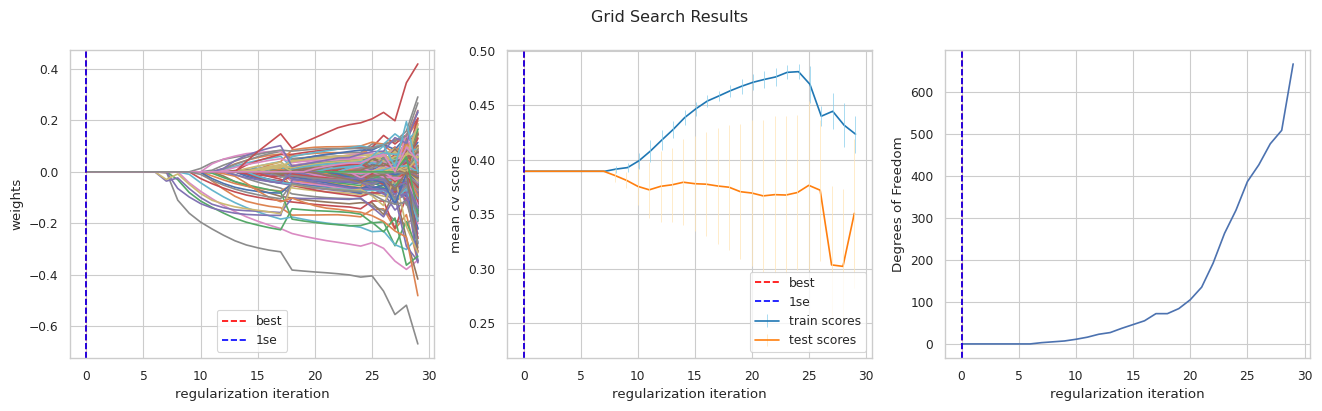

In [55]:
fig = psuper_b_cd4active.plot_grid_search()

### Run on T-cells

In [14]:
# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 80, "max_iter": 500}
preprocessing_params = {"select_genes": "all", "log": False, "normalize": False, "scale": True, "smooth": False}

In [9]:
from pypsupertime import Psupertime
psuper_b = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_b_tcells = psuper_b.run(corona_b[corona_b.obs.cell_type.isin(t_cells)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=114037
Preprocessing: done. mode='all', n_genes=10085, n_cells=114037
Grid Search CV: CPUs=5, n_folds=5


/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Regularization: done   
Refit on all data: done. accuracy=0.398318.02, n_genes=0
Total elapsed time:  1 day, 1:41:00.769999


Best idx: 0 Best Score: 0.39831808961899295 Best Lambda: 0.25 Scores std: 0.024493141622643478
1SE idx: 0 1SE Score: 0.39831808961899295 1SE Lambda: 0.25


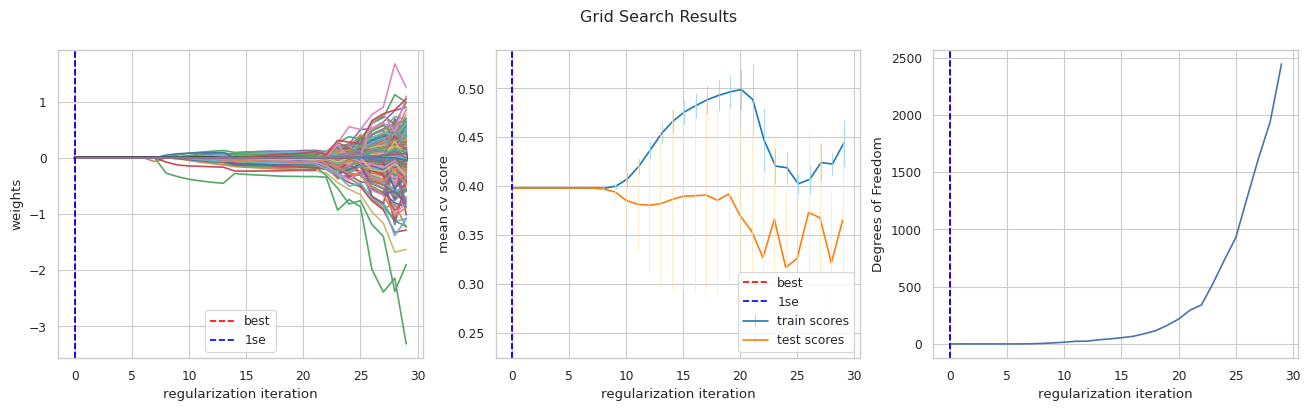

In [10]:
f = psuper_b.plot_grid_search()
#f.savefig("cohort_b_gridsearch_2.png")

In [15]:
psuper_b.refit_and_predict(cohort_b_tcells, "index", 20)

Input Data: n_genes=10085, n_cells=114037
Refit on all data: done. accuracy=0.488797.02, n_genes=201


Model Degrees of freedom 201
Accuracy: 0.48879749554969
Balanced accuracy: 0.405955755996482
Mean absolute delta: 0.8847377727271851


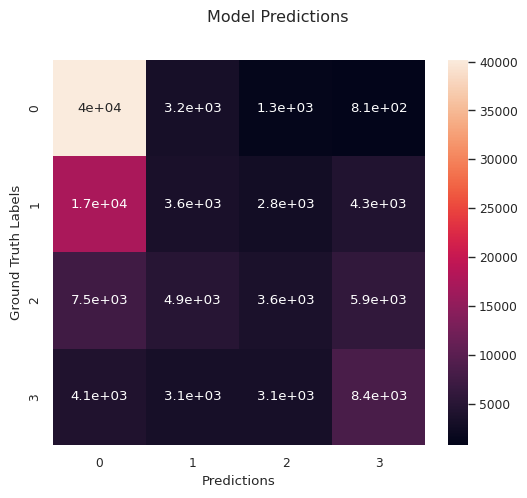

In [16]:
f = psuper_b.plot_model_perf(train=(cohort_b_tcells.X, cohort_b_tcells.obs.ordinal_label), figsize=(6,5))
#f.savefig("cohort_p_predictions_2.png")

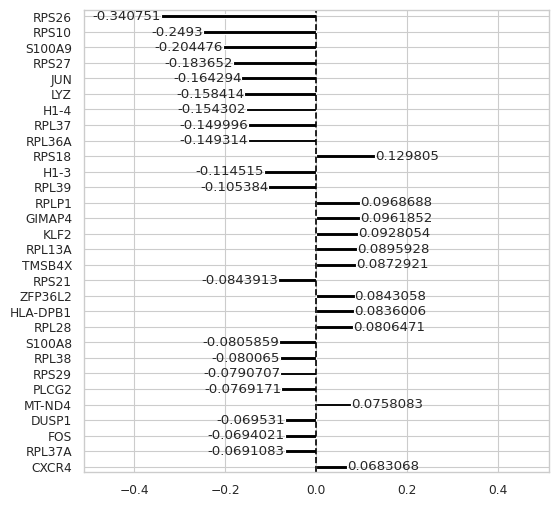

In [17]:
f = psuper_b.plot_identified_gene_coefficients(cohort_b_tcells)
#f.savefig("cohort_p_genes_2.png")

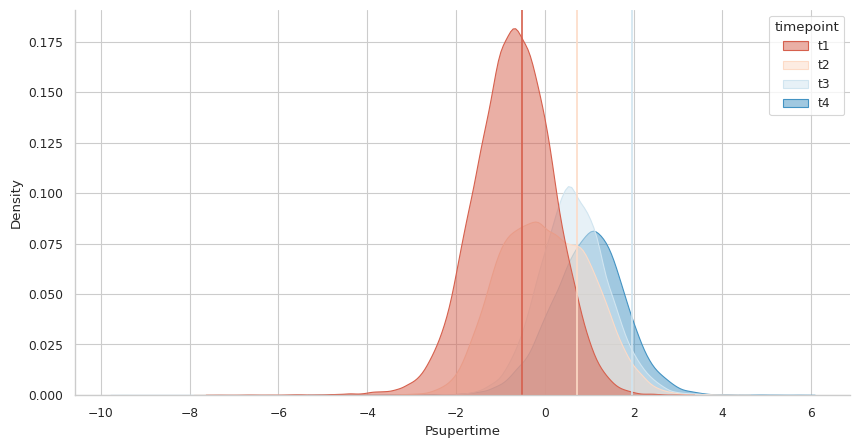

In [18]:
fig = psuper_b.plot_labels_over_psupertime(cohort_b_tcells, "timepoint")
#fig.savefig("cohort_b_labels_over_psupertime_2.png")

### Run on B-cells

In [22]:
from pypsupertime import Psupertime

# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.0005, "reg_high": 0.25, "n_params": 35}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 80, "max_iter": 500, "n_iter_no_change": 15}
preprocessing_params = {"select_genes": "all", "log": False, "normalize": False, "scale": True, "smooth": False}

psuper_b_bcells = Psupertime(n_batches=10,
                           regularization_params=regularization_params, 
                           estimator_params=estimator_params,
                           preprocessing_params=preprocessing_params)
cohort_b_bcells = psuper_b_bcells.run(corona_b[corona_b.obs.cell_type.isin(b_cells)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=12589
Preprocessing: done. mode='all', n_genes=10418, n_cells=12589
Grid Search CV: CPUs=5, n_folds=5


/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:350: RuntimeWarning: invalid value encountered in divide
  logit[:, i] = exp / (1 + exp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:350: RuntimeWarning: invalid value encountered in divide
  logit[:, i] = exp / (1 + exp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/li

/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:350: RuntimeWarning: invalid value encountered in divide
  logit[:, i] = exp / (1 + exp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:350: RuntimeWarning: invalid value encountered in divide
  logit[:, i] = exp / (1 + exp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/li

/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:350: RuntimeWarning: invalid value encountered in divide
  logit[:, i] = exp / (1 + exp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:350: RuntimeWarning: invalid value encountered in divide
  logit[:, i] = exp / (1 + exp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/li

Regularization: done   
Refit on all data: done. accuracy=0.509334.02, n_genes=45
Total elapsed time:  3:18:14.657136


Best idx: 20 Best Score: 0.42744104189998877 Best Lambda: 0.006461161466832895 Scores std: 0.0196915609968159
1SE idx: 13 1SE Score: 0.4129014046816833 1SE Lambda: 0.023226345892246557


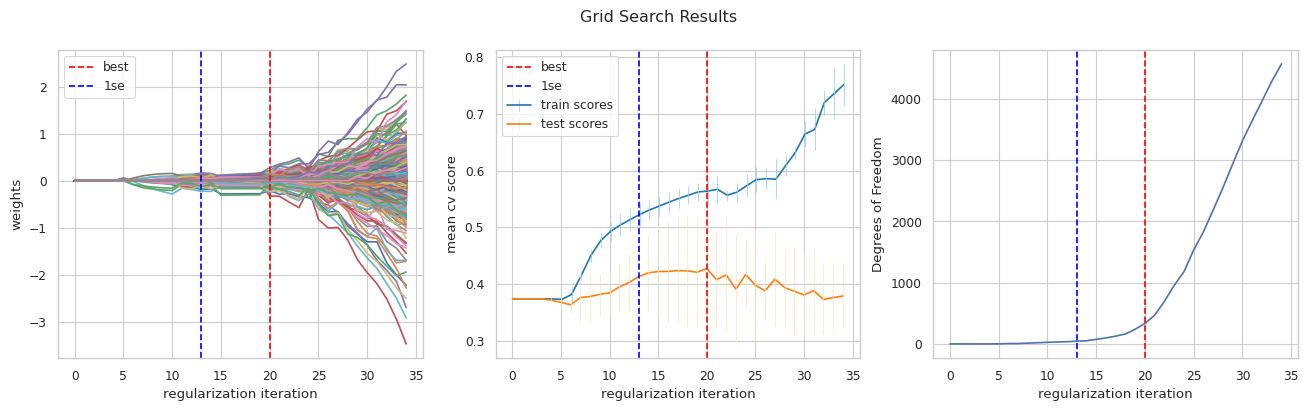

In [23]:
f = psuper_b_bcells.plot_grid_search()


In [26]:
psuper_b_bcells.refit_and_predict(cohort_b_bcells, "best")

Input Data: n_genes=10418, n_cells=12589
Refit on all data: done. accuracy=0.534753.02, n_genes=258


Model Degrees of freedom 258
Accuracy: 0.5347525617602669
Balanced accuracy: 0.43944946671758867
Mean absolute delta: 0.7750317743164854


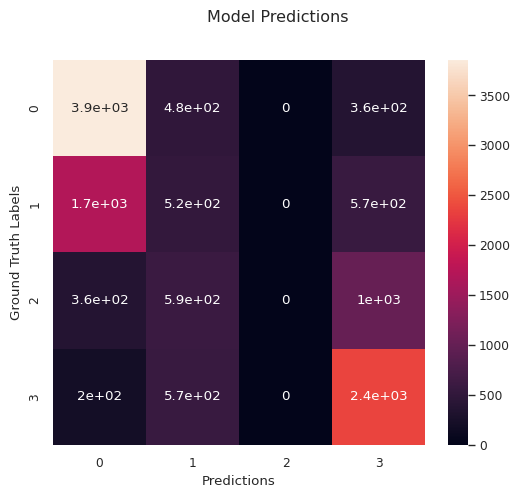

In [27]:
f = psuper_b_bcells.plot_model_perf(train=(cohort_b_bcells.X, cohort_b_bcells.obs.ordinal_label), figsize=(6,5))

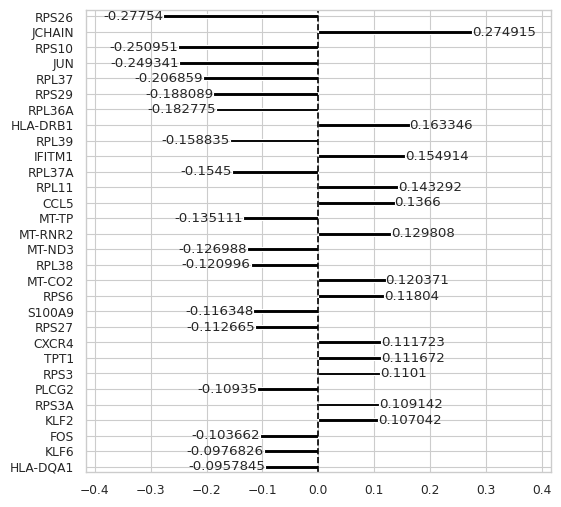

In [46]:
fig = psuper_b_bcells.plot_identified_gene_coefficients(cohort_b_bcells)